# Laboratoire 4 : Développement d'un système intelligent
#### Département du génie logiciel et des technologies de l’information

| Étudiants             | Alexandre Bleau — BLEA14058906 / David Létinaud  — LETD05129708 / Thomas Lioret   — LIOT20069605|
|-----------------------|---------------------------------------------------------|
| Cours                 | GTI770 - Systèmes intelligents et apprentissage machine |
| Session               | Automne 2019                                            |
| Groupe                | 1                                                       |
| Numéro du laboratoire | 4                                                       |
| Professeur            | Prof. LOMBAERT                                          |
| Chargé de laboratoire | Pierre-Luc Delisle                                      |
| Date                  | 18/12/2019                                              |

In [ ]:
import numpy as np

## Introduction et revue de la littérature





Pour choisir correctement les modèles à associés aux ensembles de features, il est important d'étudier ce qui a déjà été fait.
Ainsi, on s'est notamment appuyé sur l'étude "FACILITATING COMPREHENSIVE BENCHMARKING EXPERIMENTS
ON THE MILLION SONG DATASET" réalisée par l'ISMIR (International Society for Music Information Retrieval) en 2012.

La combinaison la plus performante a permis d'obtenir une précision de 27,41 % en appliquant un modèle SVM sur l'ensemble de features "Statistical Spectrum Descriptor"(SSD). Sur ces caractéristiques, l'algorithme KNN a produit une précision comparable de 27,07 %. Les autres modèles testés, baïes naïf, l'arbre de décision et "random forest" ont tous donné un taux d'exactitude entre 14 et 20 % environ. Outre le SSD, d'autres ensembles ont également fait l'objet d'essais, mais tous ont donné des résultats d'une précision inférieur, à une près. 
Les ensembles "MFCC" et "Spectral Derivates" offrent tout de même des performances comparables bien qu'inférieures à celle que peut offrir SSD.

Toutefois, cette étude n'analyse pas les performances que peut offrir un réseau de neurones. En effet, ce modèle de classification n'était pas encore très développé. On a tout de même trouvé une étude plus récente sur la classification de genre de musique. Celle-ci utilise une autre base de donnée appelée : "Free Music Archive" (FMA) constitué de 161 genres. Cette étude, "FMA: A DATASET FOR MUSIC ANALYS" est disponible ici : harxiv.org/pdf/1612.01840.pdf. Bien que le dataset soit différent, il est intéressant de noter que le modèle MLP ("MultiLayer Perceptron") performe très bien avec l'ensemble de features MFCC. Il atteint même une précision de 53%, ce qui en fait pottentiellement un très bon candidat pour notre dataset.

Ainsi, par la suite, nous étudierons 3 modèles qui semblent être les plus performants : MLP (MultiLayer Perceptron), SVM (Support Vector Machine) et RF (Random Forest). Notons que nous préferons pas utilisé KNN puisque celui-ci est très long à entrainer pour des problème de grandes dimensions.

## Question 2

Comme expliqué précedemment, le modèle MLP est un bon candidat. Toutefois, nous n'avons pas de données sur sa performance avec les ensembles de features du dataset MSD. Nous allons donc créé un modèle MLP est le tester sur tout les ensembles de features disponible pour comparer ses performances. Nous irons plus en détails dans l'ajustement des hyperparamètres par la suite.  
### Validation
Nous utiliserons ici une méthode validation hold-out avec 80% du dataset comme données d'entrainement et 20% en tant que données de tests. Nous utilisons cette méthode de validation pour le choix du partitionnement puisqu'elle à l'avantage d'être plus rapide que la validation croisée.
### Prétraitement
Par ailleurs, on utilise l'option "stratify" de la fonction train_test_split pour que les proportions de chacune des classes soit égale dans le dataset d'entrainement et de celui de test.
On normalise aussi indépendemment chaque features par rapport à la valeur maximale dans le dataset.

#### CLASS_WEIGHTS????

### Configuration de l'environnement
Ici le programme à été exécuté sur une machine ayant les caractéristiques suivantes :

### Partitionnement des données
Pour déterminer au mieux le partitionnement des données, nous testons les performances de chaque modèle choisi avec chaque ensemble de features. Nous irons plus en détails dans l'ajustement des hyperparamètres des modèles par la suite.

In [7]:
from RN_model import RN_model
from tensorflow.keras.callbacks import TensorBoard
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
import shutil
import time
import numpy as np
from functions import get_data, plot_perf_epochs,plot_perf_delay

In [2]:
direct_path_tab = []
direct_path_tab.append("./tagged_feature_sets/msd-ssd_dev/msd-ssd_dev.csv")
direct_path_tab.append("./tagged_feature_sets/msd-jmirmfccs_dev/msd-jmirmfccs_dev.csv")
direct_path_tab.append("./tagged_feature_sets/msd-jmirspectral_dev/msd-jmirspectral_dev.csv")
direct_path_tab.append("./tagged_feature_sets/msd-jmirderivatives_dev/msd-jmirderivatives_dev.csv")
direct_path_tab.append("./tagged_feature_sets/msd-jmirlpc_dev/msd-jmirlpc_dev.csv")
direct_path_tab.append("./tagged_feature_sets/msd-jmirmoments_dev/msd-jmirmoments_dev.csv")
direct_path_tab.append("./tagged_feature_sets/msd-marsyas_dev_new/msd-marsyas_dev_new.csv")
direct_path_tab.append("./tagged_feature_sets/msd-mvd_dev/msd-mvd_dev.csv")
direct_path_tab.append("./tagged_feature_sets/msd-rh_dev_new/msd-rh_dev_new.csv")
direct_path_tab.append("./tagged_feature_sets/msd-trh_dev/msd-trh_dev.csv")

In [3]:
# MLP hyperparamaters
layer_sizes = [500]
epochs = 50
learning_rate = 0.0005
batch_size = 500

dropout = 0.5

In [5]:
training_delay_RN = []
predicting_delay_RN = []
history_obj = []
cpt = 0
best_accuracy_RN = 0
f1_RN = []
acc_RN = []

In [4]:
try:      
    shutil.rmtree('./logs')
except:
    print("nothing to delete")
# Callbacks pour affichage des performances dans tensorboard : callback pour chaque hyperparamètre
tensorboard_callback = []
for i in range(len(direct_path_tab)):
    tensorboard_callback.append(TensorBoard(log_dir="logs\{}".format(i)))
# Par invité de commande : 
# tensorboard --logdir="./logs" --port 6006

In [8]:
cpt = 0
for path_ in direct_path_tab:
    # Get data / normalize it / split into train&test
    X, Y = get_data(path_)
    X = preprocessing.normalize(X, norm='max',axis = 0)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8,random_state=60, stratify=Y)  # 80% training and 20% test

    # Calcul du nombres de features/classes et taille du dataset
    nb_features = len(X[0])
    nb_classes = max(Y)+1
    train_size = len(X)

    model = RN_model(layer_sizes, dropout, learning_rate, nb_features, nb_classes)
    
    #### Apprentissage                                                                                                                                                               
    start = time.time()                                                                                                                   
    hist_obj = model.fit(X_train[0:train_size], Y_train[0:train_size], batch_size = batch_size, epochs = epochs, validation_data=(X_test, Y_test), callbacks = [tensorboard_callback[cpt]]) 
    end = time.time()
    training_delay_RN.append(end - start)
    
    history_obj.append( list(hist_obj.history.values()))

    #### Prédiction                                                                                                                                                                  
    start = time.time()
    Y_pred_temp = model.predict(X_test)
    end = time.time()
    predicting_delay_RN.append(end - start)

    # Remise en forme de Y_pred
    Y_pred = []
    for i in Y_pred_temp:
        Y_pred.append(np.argmax(i)) 
    
    f1 = metrics.f1_score(Y_test, Y_pred,average='weighted')
    acc = metrics.accuracy_score(Y_test, Y_pred)
    print("acc :", acc,"f1 :", f1)
    
    f1_RN.append(f1)
    acc_RN.append(acc)
    cpt+=1

Train on 143644 samples, validate on 35911 samples
Epoch 1/50
143644/143644 [==============================] - 7s 48us/sample - loss: 2.7883 - acc: 0.1633 - val_loss: 2.5980 - val_acc: 0.2090
Epoch 2/50
143644/143644 [==============================] - 8s 56us/sample - loss: 2.5832 - acc: 0.2113 - val_loss: 2.5262 - val_acc: 0.2287
Epoch 3/50
143644/143644 [==============================] - 6s 42us/sample - loss: 2.5257 - acc: 0.2293 - val_loss: 2.4779 - val_acc: 0.2426
Epoch 4/50
143644/143644 [==============================] - 6s 41us/sample - loss: 2.4905 - acc: 0.2412 - val_loss: 2.4471 - val_acc: 0.2539
Epoch 5/50
143644/143644 [==============================] - 6s 40us/sample - loss: 2.4659 - acc: 0.2471 - val_loss: 2.4293 - val_acc: 0.2612
Epoch 6/50
143644/143644 [==============================] - 6s 45us/sample - loss: 2.4441 - acc: 0.2544 - val_loss: 2.4148 - val_acc: 0.2643
Epoch 7/50
143644/143644 [==============================] - 6s 45us/sample - loss: 2.4286 - acc: 0.2593

Epoch 7/50
143644/143644 [==============================] - 4s 28us/sample - loss: 2.7055 - acc: 0.1813 - val_loss: 2.6797 - val_acc: 0.18880s - loss: 2.7062 - ac
Epoch 8/50
143644/143644 [==============================] - 4s 31us/sample - loss: 2.6921 - acc: 0.1852 - val_loss: 2.6645 - val_acc: 0.1943
Epoch 9/50
143644/143644 [==============================] - 5s 32us/sample - loss: 2.6799 - acc: 0.1883 - val_loss: 2.6539 - val_acc: 0.1966
Epoch 10/50
143644/143644 [==============================] - 4s 29us/sample - loss: 2.6699 - acc: 0.1923 - val_loss: 2.6455 - val_acc: 0.1998
Epoch 11/50
143644/143644 [==============================] - 4s 29us/sample - loss: 2.6606 - acc: 0.1954 - val_loss: 2.6362 - val_acc: 0.2012
Epoch 12/50
143644/143644 [==============================] - 5s 32us/sample - loss: 2.6529 - acc: 0.1971 - val_loss: 2.6278 - val_acc: 0.2036
Epoch 13/50
143644/143644 [==============================] - 4s 29us/sample - loss: 2.6455 - acc: 0.1995 - val_loss: 2.6237 - val

143644/143644 [==============================] - 4s 26us/sample - loss: 2.7303 - acc: 0.1721 - val_loss: 2.7178 - val_acc: 0.1775
Epoch 14/50
143644/143644 [==============================] - 5s 34us/sample - loss: 2.7258 - acc: 0.1733 - val_loss: 2.7139 - val_acc: 0.1788
Epoch 15/50
143644/143644 [==============================] - 4s 31us/sample - loss: 2.7219 - acc: 0.1754 - val_loss: 2.7089 - val_acc: 0.1793
Epoch 16/50
143644/143644 [==============================] - 4s 26us/sample - loss: 2.7169 - acc: 0.1753 - val_loss: 2.7043 - val_acc: 0.1803loss:
Epoch 17/50
143644/143644 [==============================] - 4s 27us/sample - loss: 2.7127 - acc: 0.1767 - val_loss: 2.7007 - val_acc: 0.1819
Epoch 18/50
143644/143644 [==============================] - 4s 30us/sample - loss: 2.7094 - acc: 0.1780 - val_loss: 2.6965 - val_acc: 0.1828
Epoch 19/50
143644/143644 [==============================] - 4s 26us/sample - loss: 2.7045 - acc: 0.1791 - val_loss: 2.6922 - val_acc: 0.1837
Epoch 20/50
1

C:\Users\David\Anaconda3\envs\GTI 770-BIS\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


acc : 0.20074628943777673 f1 : 0.16373846305366144
Train on 143644 samples, validate on 35911 samples
Epoch 1/50
143644/143644 [==============================] - 9s 60us/sample - loss: 2.9268 - acc: 0.1300 - val_loss: 2.7739 - val_acc: 0.1650
Epoch 2/50
143644/143644 [==============================] - 8s 58us/sample - loss: 2.7488 - acc: 0.1665 - val_loss: 2.6938 - val_acc: 0.1810s: 2.7514 
Epoch 3/50
143644/143644 [==============================] - 8s 55us/sample - loss: 2.6865 - acc: 0.1810 - val_loss: 2.6424 - val_acc: 0.1955
Epoch 4/50
143644/143644 [==============================] - 8s 56us/sample - loss: 2.6455 - acc: 0.1917 - val_loss: 2.6126 - val_acc: 0.2026
Epoch 5/50
143644/143644 [==============================] - 9s 62us/sample - loss: 2.6211 - acc: 0.1978 - val_loss: 2.6009 - val_acc: 0.2021
Epoch 6/50
143644/143644 [==============================] - 9s 60us/sample - loss: 2.6048 - acc: 0.2021 - val_loss: 2.5771 - val_acc: 0.2104
Epoch 7/50
143644/143644 [================

C:\Users\David\Anaconda3\envs\GTI 770-BIS\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


acc : 0.20322463869009497 f1 : 0.16613788766468798
Train on 143644 samples, validate on 35911 samples
Epoch 1/50
143644/143644 [==============================] - 6s 41us/sample - loss: 3.0572 - acc: 0.0958 - val_loss: 2.9393 - val_acc: 0.1317
Epoch 2/50
143644/143644 [==============================] - 5s 37us/sample - loss: 2.9148 - acc: 0.1337 - val_loss: 2.8805 - val_acc: 0.1432
Epoch 3/50
143644/143644 [==============================] - 5s 36us/sample - loss: 2.8789 - acc: 0.1419 - val_loss: 2.8614 - val_acc: 0.1465
Epoch 4/50
143644/143644 [==============================] - 5s 36us/sample - loss: 2.8641 - acc: 0.1449 - val_loss: 2.8487 - val_acc: 0.1479
Epoch 5/50
143644/143644 [==============================] - 5s 36us/sample - loss: 2.8523 - acc: 0.1473 - val_loss: 2.8393 - val_acc: 0.1494
Epoch 6/50
143644/143644 [==============================] - 5s 35us/sample - loss: 2.8427 - acc: 0.1490 - val_loss: 2.8302 - val_acc: 0.1518
Epoch 7/50
143644/143644 [==========================

C:\Users\David\Anaconda3\envs\GTI 770-BIS\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


acc : 0.1784689927877252 f1 : 0.13656309309069015
Train on 143644 samples, validate on 35911 samples
Epoch 1/50
143644/143644 [==============================] - 6s 41us/sample - loss: 3.1478 - acc: 0.0926 - val_loss: 2.9573 - val_acc: 0.1430
Epoch 2/50
143644/143644 [==============================] - 5s 33us/sample - loss: 2.8693 - acc: 0.1463 - val_loss: 2.7705 - val_acc: 0.1657
Epoch 3/50
143644/143644 [==============================] - 5s 33us/sample - loss: 2.7725 - acc: 0.1669 - val_loss: 2.7129 - val_acc: 0.1824
Epoch 4/50
143644/143644 [==============================] - 5s 33us/sample - loss: 2.7155 - acc: 0.1838 - val_loss: 2.6518 - val_acc: 0.2055
Epoch 5/50
143644/143644 [==============================] - 5s 33us/sample - loss: 2.6734 - acc: 0.1967 - val_loss: 2.6180 - val_acc: 0.2119
Epoch 6/50
143644/143644 [==============================] - 5s 33us/sample - loss: 2.6430 - acc: 0.2040 - val_loss: 2.6032 - val_acc: 0.2160
Epoch 7/50
143644/143644 [===========================

143644/143644 [==============================] - 6s 42us/sample - loss: 2.7183 - acc: 0.1856 - val_loss: 2.7079 - val_acc: 0.1901
Epoch 15/50
143644/143644 [==============================] - 6s 41us/sample - loss: 2.7153 - acc: 0.1870 - val_loss: 2.7066 - val_acc: 0.1904
Epoch 16/50
143644/143644 [==============================] - 6s 44us/sample - loss: 2.7129 - acc: 0.1873 - val_loss: 2.7044 - val_acc: 0.1896
Epoch 17/50
143644/143644 [==============================] - 6s 41us/sample - loss: 2.7106 - acc: 0.1881 - val_loss: 2.7017 - val_acc: 0.1918
Epoch 18/50
143644/143644 [==============================] - 6s 41us/sample - loss: 2.7070 - acc: 0.1898 - val_loss: 2.6989 - val_acc: 0.1913
Epoch 19/50
143644/143644 [==============================] - 6s 43us/sample - loss: 2.7043 - acc: 0.1886 - val_loss: 2.6976 - val_acc: 0.1909
Epoch 20/50
143644/143644 [==============================] - 6s 41us/sample - loss: 2.7032 - acc: 0.1895 - val_loss: 2.6954 - val_acc: 0.1920
Epoch 21/50
143644

C:\Users\David\Anaconda3\envs\GTI 770-BIS\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


acc : 0.20024505026315056 f1 : 0.16465149509434052
Train on 143644 samples, validate on 35911 samples
Epoch 1/50
143644/143644 [==============================] - 14s 97us/sample - loss: 2.9545 - acc: 0.1341 - val_loss: 2.8105 - val_acc: 0.1681
Epoch 2/50
143644/143644 [==============================] - 13s 88us/sample - loss: 2.7932 - acc: 0.1700 - val_loss: 2.7469 - val_acc: 0.1779
Epoch 3/50
143644/143644 [==============================] - 12s 87us/sample - loss: 2.7365 - acc: 0.1811 - val_loss: 2.7058 - val_acc: 0.1900
Epoch 4/50
143644/143644 [==============================] - 13s 87us/sample - loss: 2.7025 - acc: 0.1891 - val_loss: 2.6827 - val_acc: 0.1944
Epoch 5/50
143644/143644 [==============================] - 12s 86us/sample - loss: 2.6804 - acc: 0.1946 - val_loss: 2.6691 - val_acc: 0.1980
Epoch 6/50
143644/143644 [==============================] - 12s 86us/sample - loss: 2.6631 - acc: 0.1986 - val_loss: 2.6555 - val_acc: 0.2020
Epoch 7/50
143644/143644 [====================

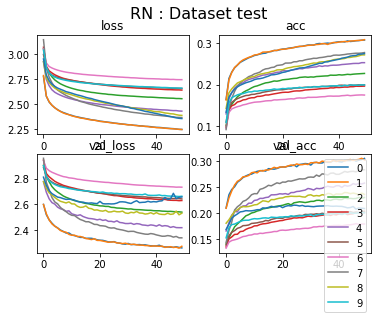

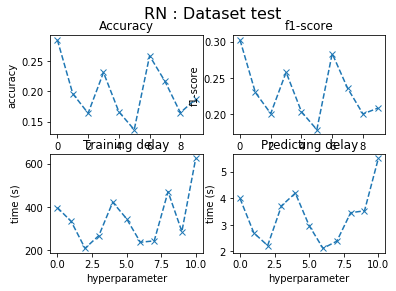

In [9]:
# Mise en forme des données pour l'affichage
ho = np.array(history_obj)
ho = ho.transpose(1,2,0)  

# Pour affichage
sub_title = ['loss','acc','val_loss','val_acc']
x_lab = "epochs"
leg = [str(i) for i in range(len(direct_path_tab))]  
titre = "RN : Dataset test"                                                                                                                                         

plot_perf_epochs(ho, leg, titre ,sub_title)
plot_perf_delay(f1_RN,acc_RN,training_delay_RN,predicting_delay_RN,titre)

On remarque que le réseau de neurones performe mieux pour les dataset 0, 3 et 6, c'est à dire avec les ensemble de features : SSD, derivates et maryas.

Pour faire un choix éclairé, on réalise des tests similaires pour les 2 autres modèles choisis.

## Question 3
### Description des modèles et justifications

## Question 4
### Matrice des expérimentations

### Matrice des résultats de l'étude des hyperparamètres

### Graphiques

### Discussion

## Question 5
### Présentation de la conception

## Question 6
### Hyperparamètres des modèles choisis dans la conception

### Matrice des résultats

### Discussion

## Question 7 
### Formulation des recommandations

## Conclusion